# Filtering expanded dataset

## Core Imports

In [1]:
# Generic Imports
import matplotlib.pyplot as plt
import pandas as pd

# File I/O
from pathlib import Path
import csv, json

# Typing and Subclassing
from typing import Iterable, Optional, Union
from dataclasses import dataclass, field

# Cheminformatics
from rdkit import Chem

# Custom imports
from polymerist.rdutils import rdkdraw
from polymerist.smileslib import substructures
from polymerist.monomers import specification

DIM    = 300
ASPECT = 3/2
rdkdraw.set_rdkdraw_size(DIM, ASPECT)
rdkdraw.disable_substruct_highlights()

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

## Loading desired dataset

In [2]:
# input_data_path = FMT_DATA_DIR / 'nipu_urethanes_FMT.csv'
input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
# input_data_path = FMT_DATA_DIR / '221010_trainingdata_DP-18_expanded_FMT.csv'
df = pd.read_csv(input_data_path)

## Defining queries for illegal chemistries

In [3]:
illegal_chem_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : substructures.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : substructures.SPECIAL_QUERY_MOLS['halogen'],
}

## Loading and backmapping premade reaction functional groups and templates

In [4]:
rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}
assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

with (RXN_FILES_DIR / 'rxn_backmap.json').open('w') as backmap_file:
    json.dump(rxn_backmap, backmap_file, indent=4)

In [5]:
from polymerist.rdutils.reactions import reactions

with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as file:
    fn_group_smarts  = json.load(file)
    
fn_group_queries = { # RDKit Mols generated from SMARTS queries
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

In [6]:
banned_monomers = [ # monomers which are, for one reason or another, disallowed
    'CC(C)(C)c1cc(c(Oc2ccc(cc2)N(c3ccc(N)cc3)c4ccc(N)cc4)c(c1)C(C)(C)C)C(C)(C)C'  # the extraordinary number of symmetries of this amine ("4-N-(4-aminophenyl)-4-N-[4-(2,4,6-tritert-butylphenoxy)phenyl]benzene-1,4-diamine")... 
]                                                                                 # ...mean it takes impractically long to isomorphism match during the Topology partition step

banned_monomer_queries = {}
for smiles in banned_monomers:
    exp_spi = specification.expanded_SMILES(smiles, assign_map_nums=False)
    banned_monomer_queries[smiles] = Chem.MolFromSmiles(exp_spi, sanitize=False)

## Utility functions

In [7]:
from enum import Enum, auto

@dataclass
class MonomerInfo:
    '''For encapsulating salient info about an individual monomer'''
    smiles        : str
    fn_group_name : str
    IUPAC_name    : str

class FilterRejectionReason(Enum):
    '''For capturing information about which filtering step a monomer didn't pass'''
    BAD_NUM_MONOMERS      = auto()
    ILLEGAL_ATOMS         = auto()
    NO_RXN_TEMPLATE_MATCH = auto()
    BAD_NUM_FN_GRPS       = auto()
    NO_IUPAC_NAME         = auto()
    BANNED_MONOMER        = auto()

In [8]:
from polymerist.monomers import specification
from polymerist.smileslib.chemdbqueries import get_property_from_smiles


def process_monomer_input(smiles : str, mech_name : str) -> Union[FilterRejectionReason, list[MonomerInfo]]:
    '''For screening and expanding SMILES input to the MD polymer building workflow'''
    # 1) Determine number of distrinct monomers in passed SMILES string
    indiv_smiles = smiles.split('.') # opting for direct string-based approach here rather than RDKit Mol fragmenting for speed, and to avoid clunky str -> Mol -> str conversion
    num_monomers = len(indiv_smiles)
    if num_monomers != 2:
        return FilterRejectionReason.BAD_NUM_MONOMERS
    
    # Generate expanded SMILES string and corresponding RDKit Mol for all monomers
    monomers_by_exp_smiles : dict[str, Chem.Mol] = {}
    exp_smiles_by_monomers : dict[Chem.Mol, str] = {} # reverse lookup to figure out the correct smiles given a molecule
    indiv_monomers         : list[Chem.Mol] = []
    
    for smi in indiv_smiles: # wait to expand SMILES until after count filtering for speed
        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)

        # 2) Catch monomers with illegal atoms or, if none are present, generate expanded SMILES string and corresponding RDKit Mol for all monomers
        if any(substructures.matching_labels_from_substruct_dict(monomer, illegal_chem_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.ILLEGAL_ATOMS

        # 3) Exclude any monomers which are structurally disallowed
        if any(substructures.matching_labels_from_substruct_dict(monomer, banned_monomer_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.BANNED_MONOMER
        
        indiv_monomers.append(monomer)
        monomers_by_exp_smiles[exp_smi] = monomer
        exp_smiles_by_monomers[monomer] = exp_smi

    # 4) Determine if monomer functionalizations match the advertised rxn, and if so in what order they should appear
    reactive_groups : list[str] = rxn_groups[rxn_backmap[mech_name]]
    rxn = rxns[rxn_backmap[mech_name]]
    mono_order = rxn.valid_reactant_ordering(indiv_monomers)
    if mono_order is None:
        return FilterRejectionReason.NO_RXN_TEMPLATE_MATCH

    # produce monomers based on a valid ordering if one is found
    mono_info_list : list[MonomerInfo] = []
    for monomer, mono_fn_group in zip(mono_order, reactive_groups, strict=True): # strict just gives one further safeguard that a 1:1 reactive group to monomer mapping has been found
        smiles = exp_smiles_by_monomers[monomer]
        # 5) Determine if all monomers are only have the desired functionalization numbers 
        if substructures.num_substruct_queries_distinct(monomer, fn_group_queries[mono_fn_group]) != 2:
            return FilterRejectionReason.BAD_NUM_FN_GRPS
        
        # 6) Query IUPAC names for each monomer - NOTE: not done in the monomer expansion loop as the name query is the slowest step and should preferably alled as few times as possible
        iupac_name = get_property_from_smiles(smiles, prop_name='iupac_name')
        if iupac_name is None:
            return FilterRejectionReason.NO_IUPAC_NAME
        
        # if a monomer has gotten here, that means it's passed!
        mono_info = MonomerInfo(
            smiles=smiles,
            fn_group_name=mono_fn_group,
            IUPAC_name=iupac_name.lower() # enforce lower-casing for consistency
        )
        mono_info_list.append(mono_info)

    return mono_info_list

## Generalizing and simplifying monomer screening procedure

In [ ]:
def process_monomer_input_updated(monomer_smiles : str, rxn_smarts : str) -> Union[FilterRejectionReason, MonomerInfo]:
    indiv_smiles = monomer_smiles.split('.') 
    rxn_template = reactions.AnnotatedReaction.from_smarts(rxn_smarts)

    # 0) perform initial quick-and-dirty string-based monomer count for speed
    if len(indiv_smiles) != rxn_template.GetNumReactantTemplates():
        return FilterRejectionReason.BAD_NUM_MONOMERS
    ...

In [15]:
rxn_smarts = {
    mechanism : rxns[rxnname].to_smarts()
        for mechanism, rxnname in rxn_backmap.items()
}
rxn_smarts

{'amide': '[#7:1](-[*:2])(-[#1])-[#1:3].[#8](-[#6:4](=[#8:5])-[*:6])-[#1]>>[#7:1](-[*:2])(-[#1:3])-[#6:4](=[#8:5])-[*:6]',
 'carbonate': '[#8:1](-[*:2])-[#1].[#17]-[#6:3](=[#8:4])-[*:5]>>[#8:1](-[*:2])-[#6:3](=[#8:4])-[*:5]',
 'ester': '[#8:1](-[*:2])-[#1].[#8](-[#6:3](=[#8:4])-[*:5])-[#1]>>[#8:1](-[*:2])-[#6:3](=[#8:4])-[*:5]',
 'imide': '[#7:1](-[*:2])(-[#1])-[#1].[*:3]-[#6:4](=[#8:5])-[#8]-[#6:6](=[#8:7])-[*:8]>>[#7:1](-[*:2])(-[#6:4](-[*:3])=[#8:5])-[#6:6](=[#8:7])-[*:8]',
 'urethane': '[#8:1]=[#6:2]=[#7:3]-[*:4].[#8:5](-[*:6])-[#1:7]>>[#8:1]=[#6:2](-[#7:3](-[*:4])-[#1:7])-[#8:5]-[*:6]',
 'NIPU': '[*:1]-[#6:2]1(-[#1:3])-[#8:4]-[#6:5](=[#8:6])-[#8:7]-[#6:8]-1(-[#1:9])-[#1:10].[#7:11](-[*:12])(-[#1:13])-[#1:14]>>[*:1]-[#6:2](-[#1:3])(-[#8:4]-[#1:13])-[#6:8](-[#8:7]-[#6:5](=[#8:6])-[#7:11](-[*:12])-[#1:14])(-[#1:9])-[#1:10]',
 'vinyl': '[*:1]/[#6:2](-[*:3])=[#6:4](/[#1:5])-[#1:6].[*:7]/[#6:8](=[#6:9](/[#1:10])-[#1:11])-[#1:12]>>[*:1]-[#6:2](-[*:3])(-[#6:4](-[#1:5])(-[#1:6])/[#6:8](-[*

In [11]:
targ_df = df.head(20)
row = df.iloc[10]
row

smiles_monomer            Nc1cccc(N)c1.CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O...
smiles_polymer_DP2        CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O)OC3=O)cc(C(=...
smiles_polymer_DP3        CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O)N(c2cccc(N)c...
smiles_polymer_DP6        CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O)OC3=O)cc(C(=...
smiles_polymer_DP18       CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O)OC3=O)cc(C(=...
num_monomers                                                              2
mechanism                                                             imide
Glass_Transition                                                      264.5
Melt_Temp                                                               NaN
Cp_solid_slope                                                          NaN
Cp_solid_intercept                                                      NaN
Cp_liquid_slope                                                         NaN
Cp_liquid_intercept                                                     NaN
log10_ElongB

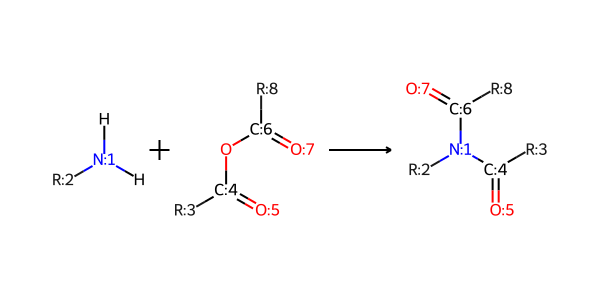

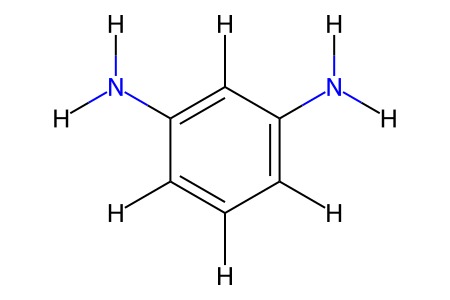

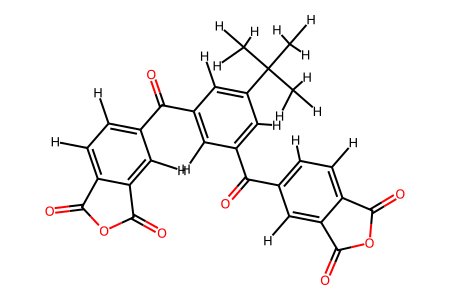

In [12]:
from rdkit.Chem import rdChemReactions


smis = row.smiles_monomer
rxnname = rxn_backmap[row.mechanism]
rxn = rxns[rxnname]
rxn_other = reactions.AnnotatedReaction.from_smarts(rdChemReactions.ReactionToSmarts(rxn))
display(rxn)

indiv_smis = smis.split('.')
indiv_mono = []
for smi in indiv_smis:
    exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
    monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)
    display(monomer)
    indiv_mono.append(monomer)

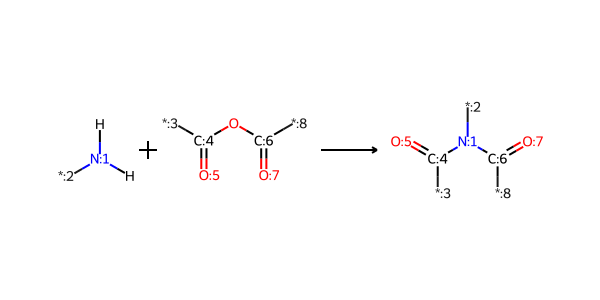

In [13]:
reactions.AnnotatedReaction.from_smarts(rxn.to_smarts())

In [14]:
rxn.smiles

'O([C:4]([*:3])=[O:5])[C:6](=[O:7])[*:8].[H][N:1]([H])[*:2]>>[N:1]([*:2])([C:4]([*:3])=[O:5])[C:6](=[O:7])[*:8]'

In [ ]:
rxn_other.valid_reactant_ordering(indiv_mono)

In [ ]:
len(indiv_smis), rxn.GetNumReactantTemplates()

In [ ]:
combo = Chem.CombineMols(*indiv_mono)
combo

In [ ]:
full_smi = Chem.MolToSmiles(combo, canonical=False)
full_smi

In [ ]:
for i, monomer in enumerate(indiv_mono):
    rxn_template = rxn.GetReactantTemplate(i)
    n_fn_groups = substructures.num_substruct_queries_distinct(monomer, rxn_template)
    print(n_fn_groups)
    # display(monomer)
    # display(rxn_template)

In [ ]:
canon_smi = Chem.CanonSmiles(full_smi)
canon_smi

In [ ]:
monomers_in_order = rxn.valid_reactant_ordering(indiv_mono)

# Filter dataset

## Generate filtered Series (either error codes or MonomerInfo) from initial dataset

In [ ]:
from rich.progress import track

targ_df = df
# targ_df = df.head(20)
# targ_df = df[df.mechanism == 'vinyl']

proc_output = []
for (i, row) in track(targ_df.iterrows(), total=len(targ_df), description='Processing SMILES dataset...'):
    proc = process_monomer_input(row.smiles_monomer, row.mechanism) # TODO : move mechanism backmap lookup here
    proc_output.append(proc)

proc_output = pd.Series(proc_output) # convert from list to Series, partition by failure state
was_rejected = proc_output.map(lambda out : isinstance(out, FilterRejectionReason))
rejects = proc_output[ was_rejected]
passes  = proc_output[~was_rejected]

## Expand successful monomers into labelled DataFrame

In [ ]:
def expand_mono_info_list(all_info : list[MonomerInfo]) -> list[str]:
    return {
        f'{attr}_monomer_{j}' : getattr(mono_info, attr)
            for j, mono_info in enumerate(all_info) # NOTE: the index "j" here is NOT the position as determined by monomer sort, but rather the index in the rxn groups ordering
                for attr in ('smiles', 'fn_group_name', 'IUPAC_name')
    }

def get_polymer_name(*monomer_names : list[str]) -> str:
    return f'poly({"-co-".join(monomer_names)})'


passes_as_dict = passes.map(expand_mono_info_list)
passes_df = pd.DataFrame.from_records(passes_as_dict.values, index=passes_as_dict.index)

result_df = pd.concat([passes_df, df.loc[passes_df.index]], axis=1) # combine expanded monomer info with original dataframe
result_df['polymer_name'] = result_df[['IUPAC_name_monomer_0', 'IUPAC_name_monomer_1']].apply(lambda row : get_polymer_name(*row.to_list()), axis=1)

result_df['rxn_name'] = result_df['mechanism'].map(rxn_backmap) # backmap to rxn template name, and assert this name to take precedence as "mechanism"
result_df.rename(columns={'mechanism' : 'mechanism_orig', 'rxn_name' : 'mechanism'}, inplace=True) 

result_df.set_index(['mechanism', 'polymer_name'], inplace=True)
result_df

## Show distribution of failure cases

In [ ]:
dim = 6
aspect= 3/2

plt.figure(figsize=(dim*aspect, dim))

ax = rejects.map(lambda x : x.value).plot(kind='hist')
ax.set_xticks([i.value for i in FilterRejectionReason])
ax.set_xticklabels([i.name for i in FilterRejectionReason], rotation=-30)

plt.show()

## Save filtered DataFrame for next steps to avoid reprocessing

In [ ]:
PROC_DATA_DIR.mkdir(exist_ok=True)
clean_input_stem = input_data_path.stem.removesuffix('_FMT')

# save filtered dataset to filtered directory to store caclulations
out_data_path = PROC_DATA_DIR / f'{clean_input_stem}_FILTERED{input_data_path.suffix}'
result_df.to_csv(out_data_path)

# also keep record of the rejected monomers (and the reasons for rejection)
rejects_data_path = PROC_DATA_DIR / f'{clean_input_stem}_REJECTED{input_data_path.suffix}'
rejects.map(lambda r : r.name).to_csv(rejects_data_path)